In [21]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# === Paths ===
keywords_path = r"E:\Coding\BDA-PySpark\realtime-pipeline\results\keywords.csv"
topics_path = r"E:\Coding\BDA-PySpark\realtime-pipeline\results\topic_results.csv"

# === Load CSVs ===
keywords_df = pd.read_csv(keywords_path)
topics_df = pd.read_csv(topics_path)

print(f"[INFO] Loaded dataframes:")
print(f"Keywords: {keywords_df.shape}")
print(f"Topics: {topics_df.shape}")

# === Merge ===
merged_df = topics_df.copy()
merged_df["keywords"] = keywords_df["keywords"]

# === Group keywords per topic ===
topic_groups = (
    merged_df.groupby("topic")["keywords"]
    .apply(lambda x: ", ".join(x.dropna().astype(str)))
    .reset_index()
)

print(f"[DEBUG] topic_groups shape: {topic_groups.shape}\n")

[INFO] Loaded dataframes:
Keywords: (141, 2)
Topics: (141, 3)
[DEBUG] topic_groups shape: (2, 2)



In [22]:
category_labels = [
    "Politics and Government",
    "Law and Justice",
    "Business and Economy",
    "Technology and Gadgets",
    "Science and Innovation",
    "Environment and Climate",
    "Health and Medicine",
    "Mental Health and Wellbeing",
    "Education and Learning",
    "Work and Careers",
    "Sports and Fitness",
    "Gaming and Esports",
    "Movies and TV Shows",
    "Music and Entertainment",
    "Art and Creativity",
    "Religion and Spirituality",
    "Philosophy and Ethics",
    "Relationships and Dating",
    "Parenting and Family Life",
    "Food and Cooking",
    "Travel and Adventure",
    "Internet Culture and Memes",
    "History and Society",
    "Animals and Nature",
    "Fashion and Lifestyle"
]


[INFO] Loading embedding model...
[INFO] Using device: cpu

[TOPIC 0] Filtered Keywords:
stellar legal case mination route unless exit stage left practically set business owner ask management tell suffering stone profit, agents working situation mplausible mean information incident fbi details contact caused, gisteren niet veel gedaan vrijdag, small clai need lawyer file clai wasted ti ms court id ti ms court youd, person seat papers paper left leaves leave harm going foul, rear view camera milar issue like bigger parking spaces coupe parking wide uk suvs suv si li, washing dishes purely ti prepping ingredients communal activity dads cooking cooking anymore cooking wrote terms storing, recently laid past decade like depending government shit currently unemployed currently works work office income, safety features gi lan departure systems high speed turns skid pan driving liberty legacy outside eyesight traction control subaru handles driving course love eyesight instructor commented, p

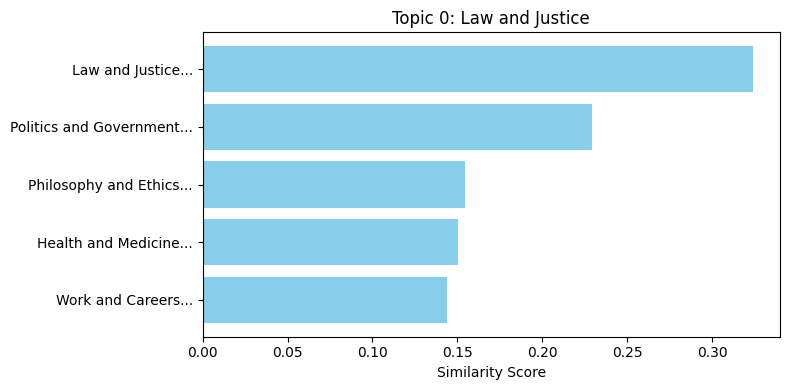


Topic 1 →
   ↳ Assigned Label: Unclear
   ↳ Top Matches:
      Internet Culture and Memes                                   : 0.218
      Food and Cooking                                             : 0.122
      Philosophy and Ethics                                        : 0.121
      Gaming and Esports                                           : 0.105
      Technology and Gadgets                                       : 0.041
--------------------------------------------------------------------------------


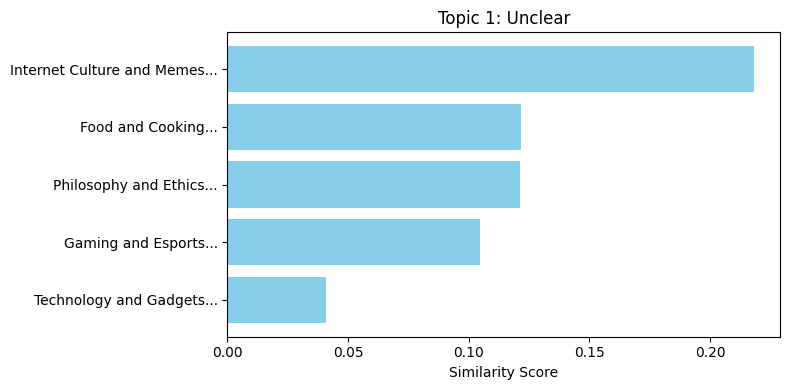

In [23]:
#=== Load model ===
print("[INFO] Loading embedding model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device=device)
print(f"[INFO] Using device: {device}")

# === Encode category labels ===
category_embeddings = model.encode(category_labels, convert_to_tensor=True, device=device)

# === Prepare topic texts (filtered keywords) ===
topic_texts = []
for _, row in topic_groups.iterrows():
    # Split, strip, and filter short keywords
    keywords = [k.strip() for k in row["keywords"].split(",") if k.strip()]
    keywords = [k for k in keywords if len(k) >= 3]  # remove keywords shorter than 3 letters

    # Deduplicate and trim
    unique_keywords = list(dict.fromkeys(keywords))  # remove duplicates, preserve order
    top_keywords = unique_keywords[:10]  # top 10 per topic

    # Join for embedding
    topic_text = " ".join(top_keywords)
    topic_texts.append(topic_text)

    # === Print summary ===
    print(f"\n[TOPIC {row['topic']}] Filtered Keywords:")
    print(", ".join(top_keywords))

# === Encode all topics at once ===
print("\n[INFO] Encoding topic clusters...")
topic_embeddings = model.encode(topic_texts, convert_to_tensor=True, device=device, batch_size=8)

# === Compute similarity & assign labels ===
print("\n[INFO] Processing topics...\n")
assigned_labels = []

for i, topic_embedding in enumerate(topic_embeddings):
    similarities = util.cos_sim(topic_embedding, category_embeddings)[0]
    similarities_np = similarities.cpu().numpy()

    # Top 5 labels
    top_indices = similarities_np.argsort()[-5:][::-1]
    top_labels = [category_labels[j] for j in top_indices]
    top_scores = similarities_np[top_indices]

    # Confidence rule
    if top_scores[0] < 0.30 or (top_scores[0] - top_scores[1]) < 0.05:
        best_label = "Unclear"
    else:
        best_label = top_labels[0]

    assigned_labels.append(best_label)

    # === Print results ===
    print(f"\nTopic {topic_groups.loc[i, 'topic']} →")
    print(f"   ↳ Assigned Label: {best_label}")
    print(f"   ↳ Top Matches:")
    for lbl, sc in zip(top_labels, top_scores):
        print(f"      {lbl[:60]:<60} : {sc:.3f}")
    print("-" * 80)

    # === Visualization ===
    plt.figure(figsize=(8, 4))
    plt.barh(range(len(top_labels)), top_scores[::-1], color='skyblue')
    plt.yticks(range(len(top_labels)), [l[:50] + "..." for l in top_labels[::-1]])
    plt.title(f"Topic {topic_groups.loc[i, 'topic']}: {best_label}")
    plt.xlabel("Similarity Score")
    plt.tight_layout()
    plt.show()